In [13]:
#!pip install mlxtend
%matplotlib notebook

## Import all the relevant libraries

In [106]:
import pandas as pd
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,InputLayer,MaxPool2D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Helper functions

In [674]:
def generate_samples(data,label,samples,take):
    GESTURES = label.classes_
    SAMPLES_PER_GESTURE = samples
    NUM_GESTURES = len(GESTURES)
    ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

    inputs = []
    outputs = []

    # read each csv file and push an input and output
    for gesture_index in range(NUM_GESTURES):
      gesture = GESTURES[gesture_index]
      print(f"Processing index {gesture_index} for gesture '{gesture}'.")

      output = ONE_HOT_ENCODED_GESTURES[gesture_index]

      df = data[data['Activity Part'] == gesture].head(take).copy().reset_index()

      # calculate the number of gesture recordings in the file
      num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

      print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

      for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):    
          index = i * SAMPLES_PER_GESTURE + j      
          #print(str(i)+"\t: "+str(j)+" =\t"+str(index))
          # normalize the input data, between 0 to 1:
          # - acceleration is between: -4 to +4
          # - gyroscope is between: -2000 to +2000
          tensor += [
          #(df['Ax'][index] + 4.0) / 8.0,
          #(df['Ay'][index] + 4.0) / 8.0,
          #(df['Az'][index] + 4.0) / 8.0,
          #(df['Gx'][index] + 500.0) / 1000.0,
          #(df['Gy'][index]  + 500.0) / 1000.0,
          #(df['Gz'][index]  + 500.0) / 1000.0,
              
          # math.sqrt(df['Ax'][index] ** 2) / 4,
          # math.sqrt(df['Ay'][index] ** 2) / 4,
          # math.sqrt(df['Az'][index] ** 2) / 4,
          # math.sqrt(df['Gx'][index] ** 2) / 500,
          # math.sqrt(df['Gy'][index] ** 2) / 500,
          # math.sqrt(df['Gz'][index] ** 2) / 500,
              df['Am'][index],
              df['Gm'][index],
          #    math.atan2(df['Ay'][index],df['Az'][index]),
        # math.atan2(-df['Ax'][index], math.sqrt(df['Ay'][index]**2 +(df['Az'][index] **2)))
          ]

        inputs.append(tensor)
        outputs.append(output)

    # convert the list to numpy array
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    return inputs, outputs

## load_sample 
Loads the data from the sample file from dir that contains sample data with Hz sampling rate

In [656]:
def load_sample(file,kg,activity):
    data =  pd.read_csv('data/csv_v3_100hz_'+str(kg)+'kg/'+str(file)+'.csv',sep= ",").rename(columns={
        'Time':'DateTime',
        'ts':'Time',
        'ax':'Ax',
        'ay':'Ay',
        'az':'Az',
        'gx':'Gx',
        'gy':'Gy',
        'gz':'Gz'
    }) 
    data['Weight'] = kg
    data['Activity'] = activity
    acc_scalar(data)
    return data

In [654]:
def acc_scalar(df):
    df['Axs'] = (df['Ax'].apply(lambda x:math.sqrt(x**2)/4))
    df['Ays'] = (df['Ay'].apply(lambda x:math.sqrt(x**2)/4))
    df['Azs'] = (df['Az'].apply(lambda x:math.sqrt(x**2)/4))
    df['Gxs'] = (df['Gx'].apply(lambda x:math.sqrt(x**2)/500.0))
    df['Gys'] = (df['Gy'].apply(lambda x:math.sqrt(x**2)/500.0))
    df['Gzs'] = (df['Gz'].apply(lambda x:math.sqrt(x**2)/500.0))

## label_activity 
Sets the label column for the dataset

In [329]:
def activity_part(df, name, start, end):
    df.loc[start:end, 'Activity Part'] = name    
    return df

## frequency
based on the timestamp calculate the sampling frequency

In [537]:
def frequency(df):
    df['Time_Delta_ms'] = (df['Time']-df['Time'].shift()).fillna(1000).astype(int)
    df['Hz'] = (1000/df['Time_Delta_ms']).astype(int)

In [538]:
def unique_labels(df):
    return df['Activity'].unique()

## Plotting functions for individual activities

In [686]:
def plot_activity(activity, df,i=1000,h=0):
    data = df[df['Activity'] == activity][['Ax','Ay','Az','Am','Gm']][h:i]
    axis = data.plot(subplots=True, figsize=(24, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_part(activity, df,i=1000,h=0):
    data = df[df['Activity Part'] == activity][['Ax','Ay','Az','Am','Gm']][h:i]
    axis = data.plot(subplots=True, figsize=(24, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_normalized(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Axs','Ays', 'Azs']][:i]
    axis = data.plot(subplots=True, figsize=(24, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_magnitude(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Am', 'Gm']][:i]
    axis = data.plot(subplots=True, figsize=(24, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))     

        
def plot_datasets(df,i=1000):
    for activity in unique_labels(df):
        plot_activity(activity, df,i)    

def plot_datasets_magnitude(df,i=1000):
    for activity in unique_labels(df):
        plot_activity_magnitude(activity, df,i)    

def plot_datasets_normalized(df,i=1000):
    for activity in unique_labels(df):
        plot_activity_normalized(activity, df,i)    

In [664]:
def magnitude(df):
    ax2 = df['Ax']**2
    ay2 = df['Ay']**2
    az2 = df['Az']**2
    am2 = ax2 + ay2 + az2
    
    gx2 = df['Gx']**2
    gy2 = df['Gy']**2
    gz2 = df['Gz']**2
    gm2 = gx2 + gy2 + gz2
    
    
    df['Am']=am2.apply(lambda x: math.sqrt(x)/4) 
    df['Gm']=gm2.apply(lambda x: math.sqrt(x)/500)
    
     #df['Pitch']=         math.atan2(df['Ay'][index],df['Az'][index])
      #   math.atan2(-df['Ax'][index], math.sqrt(df['Ay'][index]**2 +(df['Az'][index] **2)))

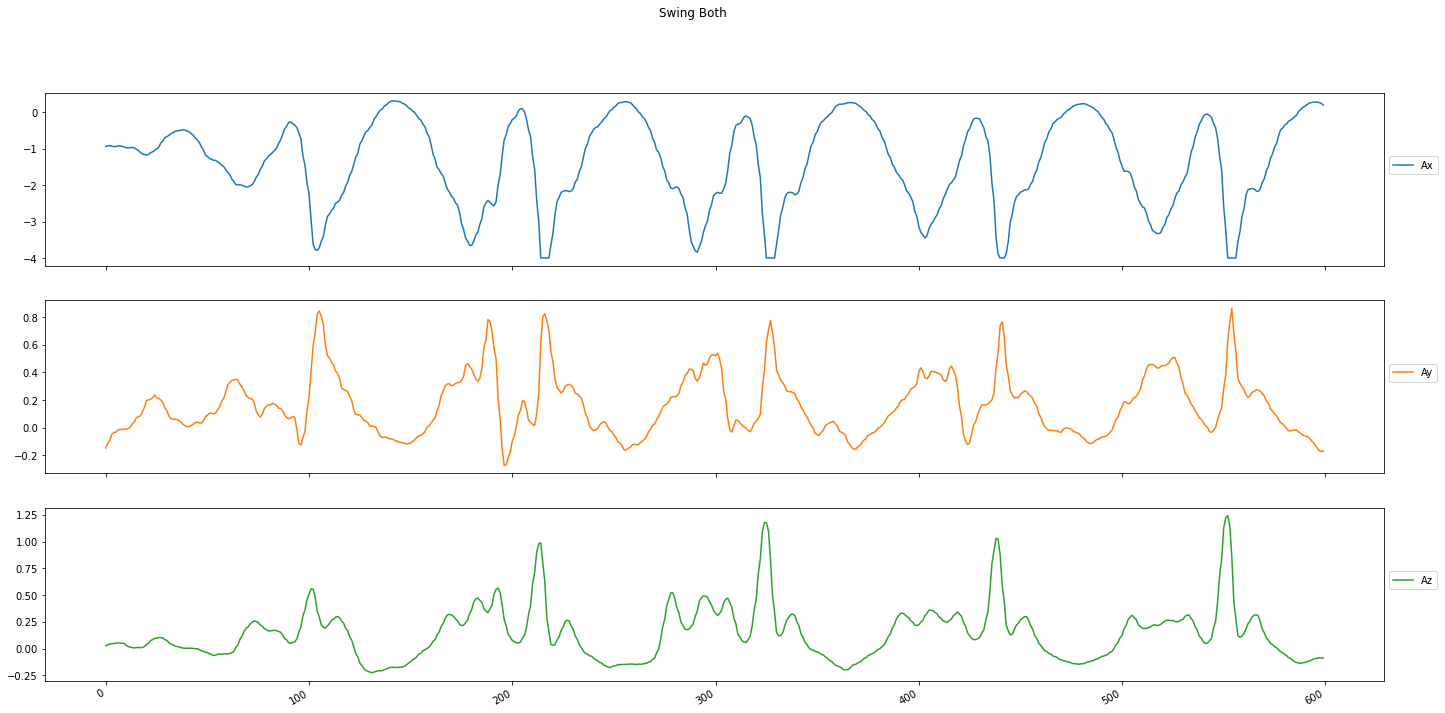

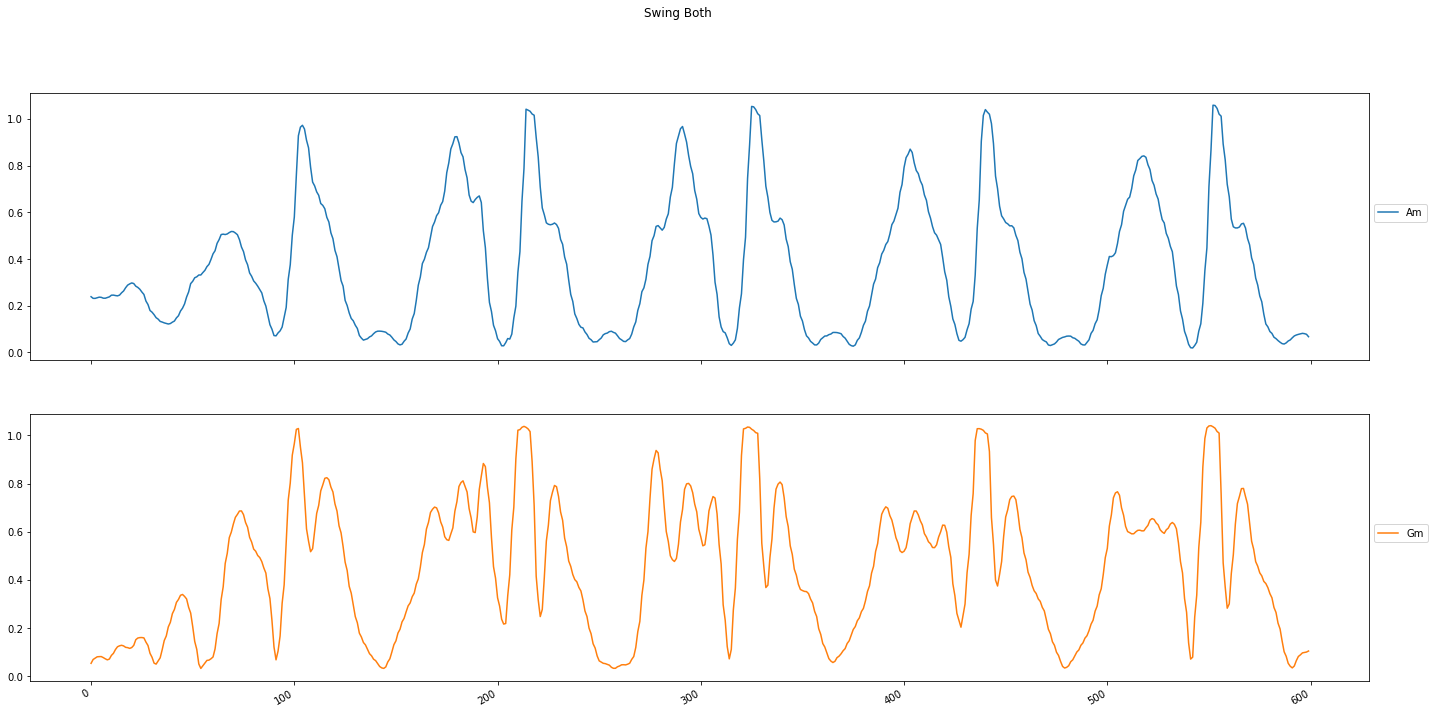

In [673]:
magnitude(df)
plot_activity('Swing Both',df,i=600)
plot_activity_magnitude('Swing Both',df,i=600)

# Import sample data
Import the sample data from files that contain accelerometer and gyro data for individual exercises.

In [677]:
'''
df_press_r=pd.DataFrame().append([
    load_sample('press_right_0',8,'Press Right'),
    load_sample('press_right_2',8,'Press Right'),
    load_sample('press_right_3',8,'Press Right')
],ignore_index=True)

df_press_l=pd.DataFrame().append([
    load_sample('press_left_0',8,'Press Left'),
    load_sample('press_left_2',8,'Press Left'),
    load_sample('press_left_3',8,'Press Left')
],ignore_index=True)

df_swing_r=pd.DataFrame().append([
    load_sample('swing_right_0',8,'Swing Right'),
    load_sample('swing_right_1',8,'Swing Right'),
    load_sample('swing_right_2',8,'Swing Right'),
    load_sample('swing_right_3',8,'Swing Right')
],ignore_index=True)

df_swing_l=pd.DataFrame().append([
    load_sample('swing_left_0',8,'Swing Left'),
    load_sample('swing_left_1',8,'Swing Left'),
    load_sample('swing_left_2',8,'Swing Left'),
    load_sample('swing_left_3',8,'Swing Left')
],ignore_index=True)
'''

df_swing_b = pd.DataFrame().append([
    load_sample('swing_both_0',8,'Swing Both'),
],ignore_index=True)
df_swing_b.describe()

,Gx,Gy,Gz,Ax,Ay,Az,Time,Weight,Axs,Ays,Azs,Gxs,Gys,Gzs
count,7586.000000,7586.000000,7586.000000,7586.000000,7586.000000,7586.000000,7.586000e+03,7586.0,7586.000000,7586.000000,7586.000000,7586.000000,7586.000000,7586.000000
mean,0.664735,6.899827,-5.083029,-1.330644,0.151565,0.162465,1.736880e+07,8.0,0.346212,0.046074,0.048924,0.074028,0.392890,0.032968
std,49.807648,241.461653,22.786097,1.164394,0.200088,0.230521,3.225098e+04,0.0,0.274841,0.042603,0.050767,0.066664,0.281110,0.033063
min,-195.236210,-500.000000,-116.287230,-4.000000,-0.271970,-0.226930,1.731078e+07,8.0,0.000092,0.000030,0.000000,0.000031,0.000061,0.000000
25%,-24.116520,-165.737155,-15.365600,-2.150755,0.004030,-0.005860,1.734065e+07,8.0,0.095253,0.016578,0.014260,0.020447,0.125458,0.010139
50%,1.892090,7.232670,-2.258300,-1.062500,0.114380,0.108520,1.737025e+07,8.0,0.265625,0.031037,0.030885,0.054321,0.372833,0.023010
75%,29.758455,230.258945,8.041380,-0.356900,0.262910,0.287717,1.739971e+07,8.0,0.537689,0.065780,0.071929,0.113884,0.623230,0.042961
max,241.348270,454.162600,105.010990,0.541020,1.046880,1.443730,1.741294e+07,8.0,1.000000,0.261720,0.360932,0.482697,1.000000,0.232574


In [159]:
# new frame with with all the activities
df = pd.DataFrame()
df = df.append([df_swing_l])

In [166]:
#df.loc[0:255,'Activity Part'] = 'swing_left_begin'
#data[data['Activity Part'] == 'swing_left_begin'].head(6000).copy()
kd = df_swing_l[df_swing_l['Activity Part'] == 'swing_left_down']['Ax'].head().copy().reindex()
kd

,index,Ax
0,321,-0.04346
1,322,-0.08752
2,323,-0.09448
3,324,-0.07190
4,325,-0.08911


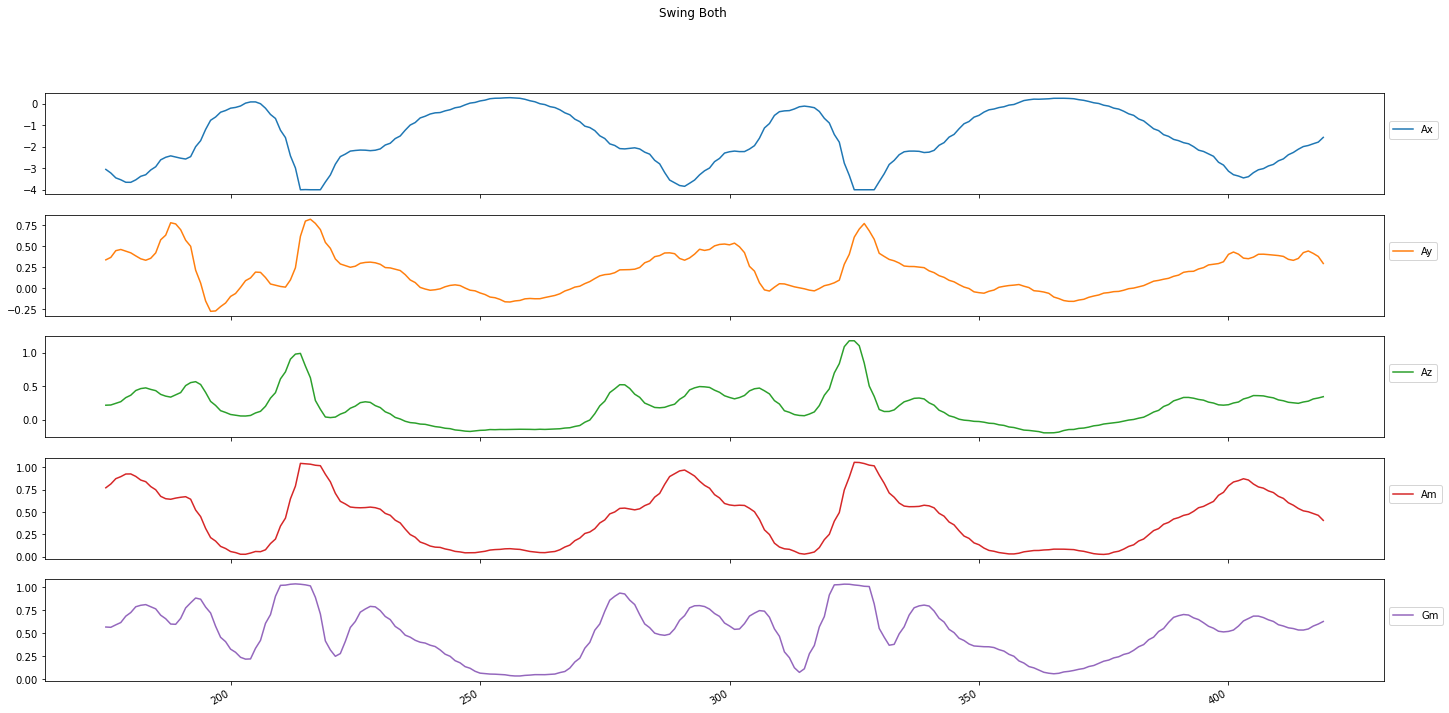

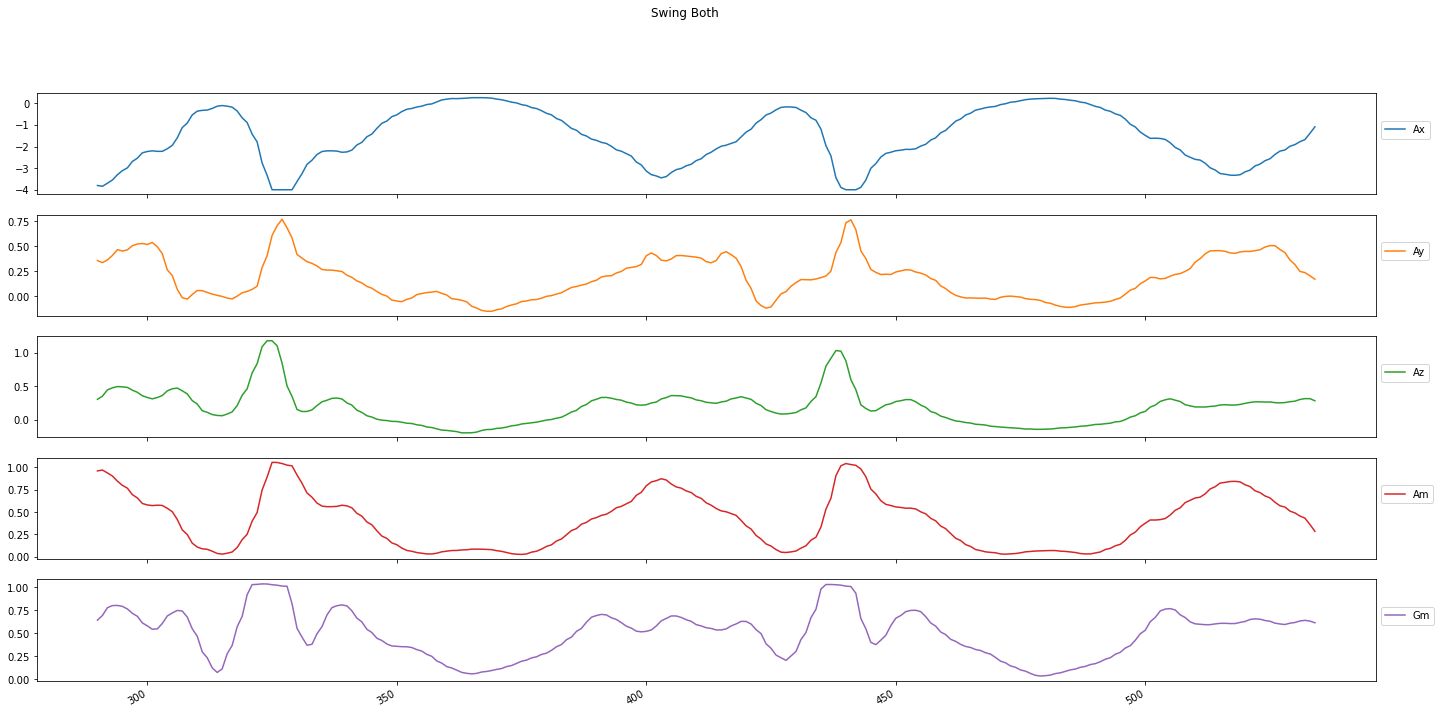

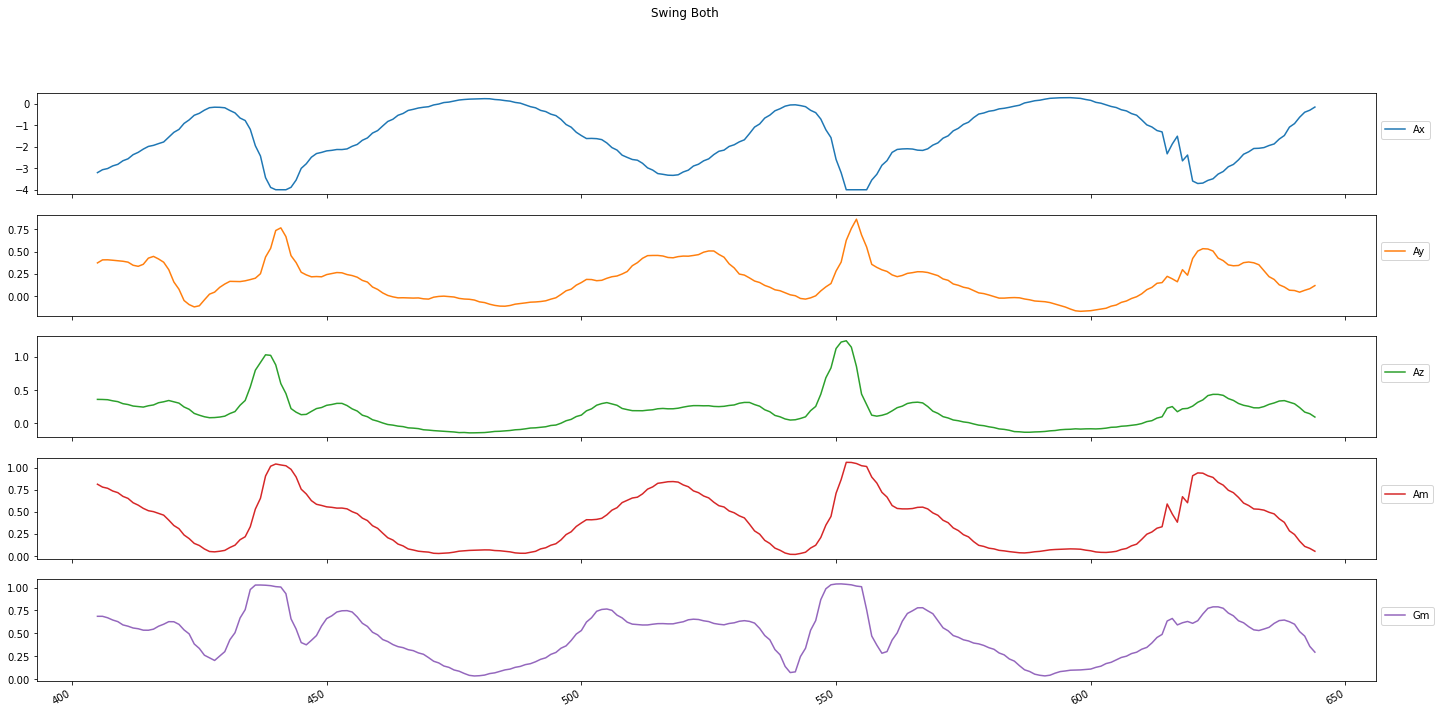

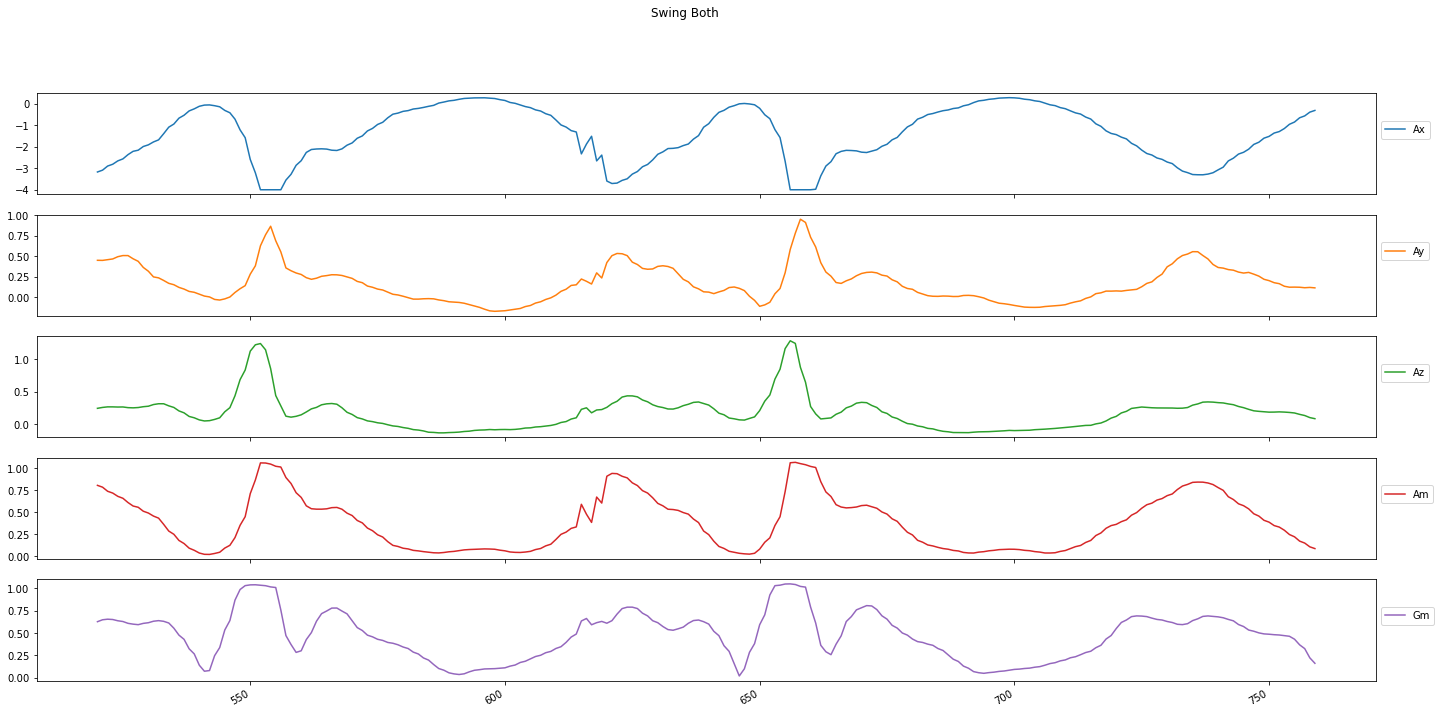

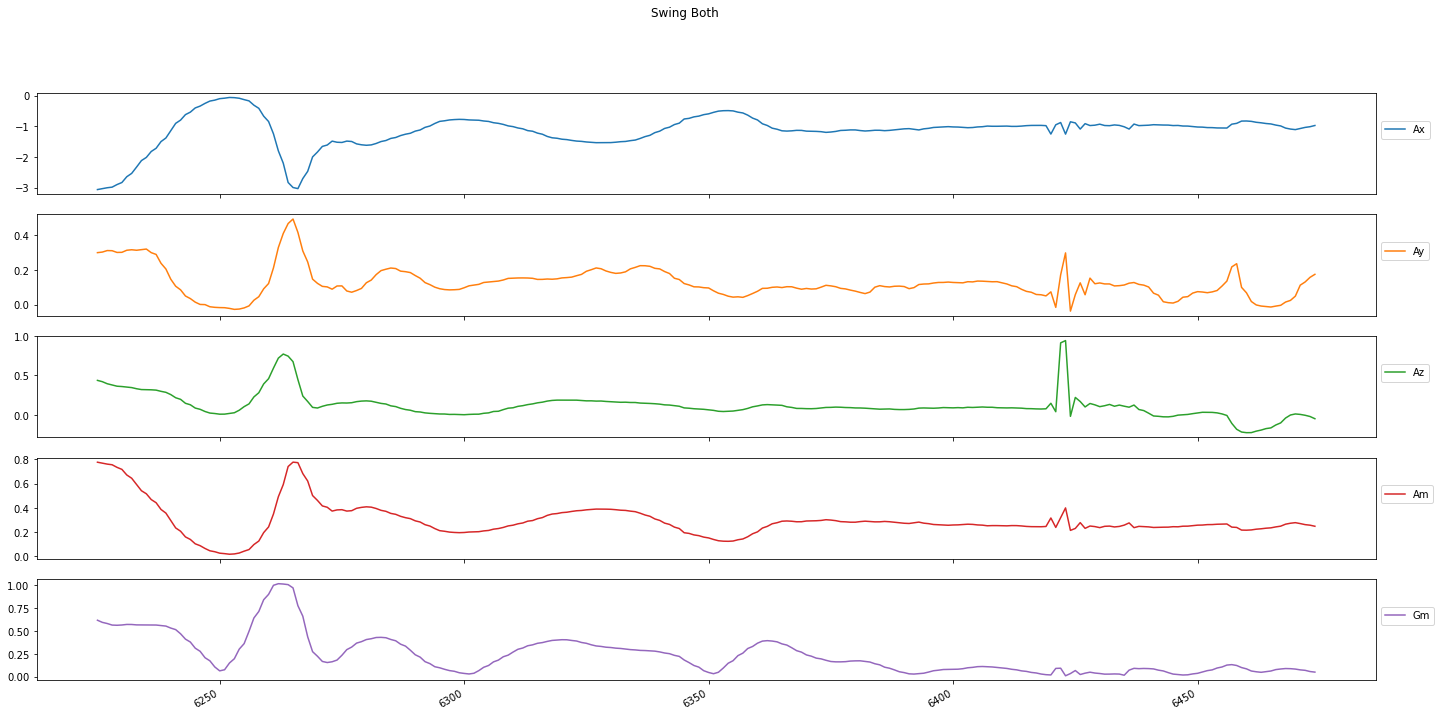

In [687]:
def swing_both(df):
    def swing_begin(a,b):
        return activity_part(df,'swing_begin',a,b)

    def swing_end(a,b):
        return activity_part(df,'swing_end',a,b)

    def swing(bottom,top,end,plot=False):
        activity_part(df,'swing_both_up',bottom,top)
        activity_part(df,'swing_both_down',top+1,end)
        if plot :
            plot_activity('Swing Both',df,h=top,i=end+200)

    df['Activity Part'] = 'unknown'
    swing(110,175,220,True)
    swing(220,290,335,True)
    swing(335,405,445,True)
    swing(445,520,560,True)
    swing(560,620,665)
    swing(665,740,775)
    swing(775,850,890)
    swing(890,965,1005)
    swing(1005,1065,1090)
    swing(1090,1170,1220)
    swing(1220,1280,1320)
    swing(1320,1400,1435)
    swing(1435,1465,1545)
    swing(1545,1625,1670)
    swing(1670,1740,1780)
    swing(1780,1860,1890)
    swing(1890,1965,2010)
    swing(2010,2080,2120)
    swing(2120,2200,2235)
    swing(2235,2320,2355)
    swing(2355,2430,2470)
    swing(2470,2540,2575)
    swing(2575,2665,2695)
    swing(2695,2780,2820)
    swing(2820,2890,2935)
    swing(2935,3020,3055)
    swing(3055,3135,3170)
    swing(3170,3255,3280)
    swing(3280,3370,3415)
    swing(3415,3475,3515)
    swing(3515,3585,3640)
    swing(3640,3720,3750)
    swing(3750,3835,3875)
    swing(3875,3950,3990)
    swing(3990,4070,4120)
    swing(4120,4190,4240)
    swing(4240,4320,4350)
    swing(4350,4425,4475)
    swing(4475,4550,4585)
    swing(4585,4670,4720)
    swing(4720,4780,4835)
    swing(4835,4920,4960)
    swing(4960,5030,5070)
    swing(5070,5160,5200)
    swing(5200,5275,5320)
    swing(5320,5400,5440)
    swing(5440,5520,5570)
    swing(5570,5640,5680)
    swing(5680,5750,5785)
    swing(5785,5870,5910)
    swing(5910,5980,6040)
    swing(6040,6110,6150)
    swing(6150,6225,6275,True)
    return df
#df_swing_b
magnitude(df_swing_b)
df_swing_b = swing_both(df_swing_b)

Processing index 0 for gesture 'swing_both_down'.
	There are 53 recordings of the swing_both_down gesture.
Processing index 1 for gesture 'swing_both_up'.
	There are 60 recordings of the swing_both_up gesture.
Processing index 2 for gesture 'unknown'.
	There are 20 recordings of the unknown gesture.


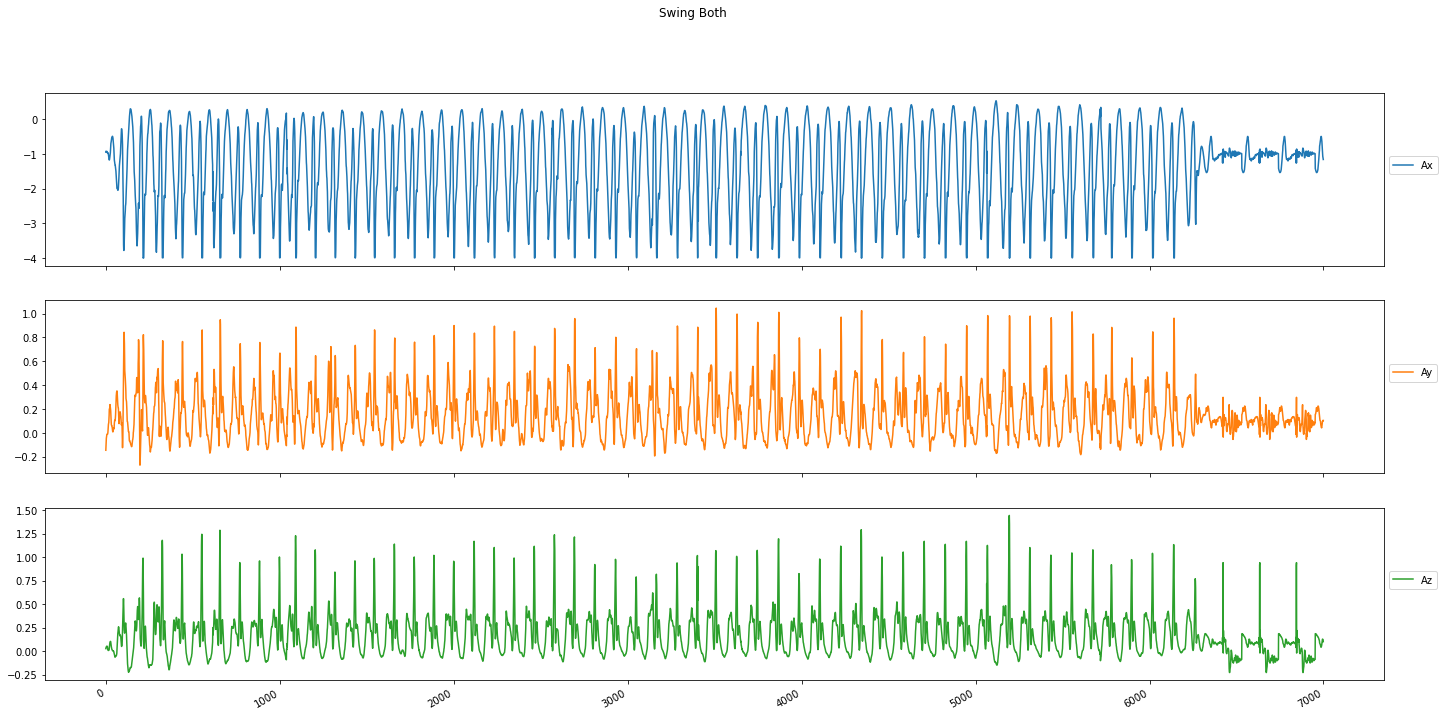

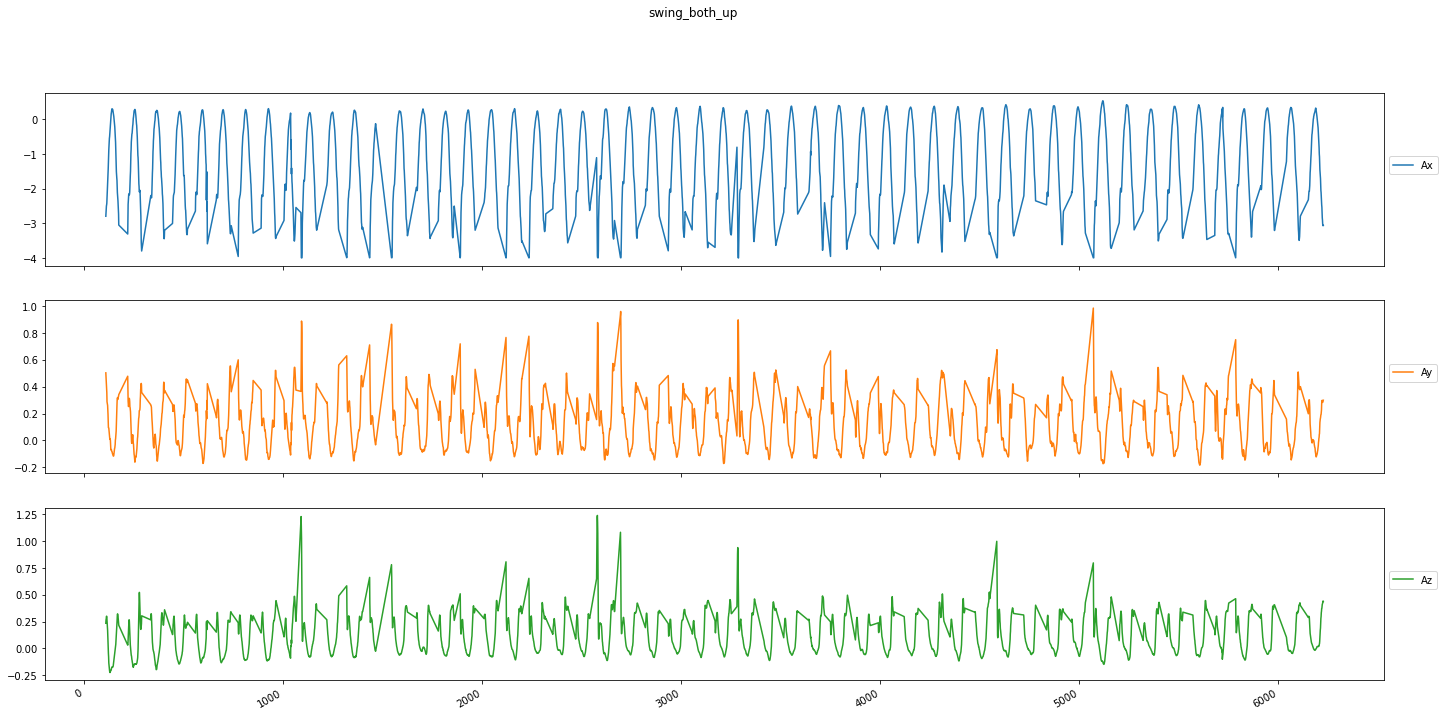

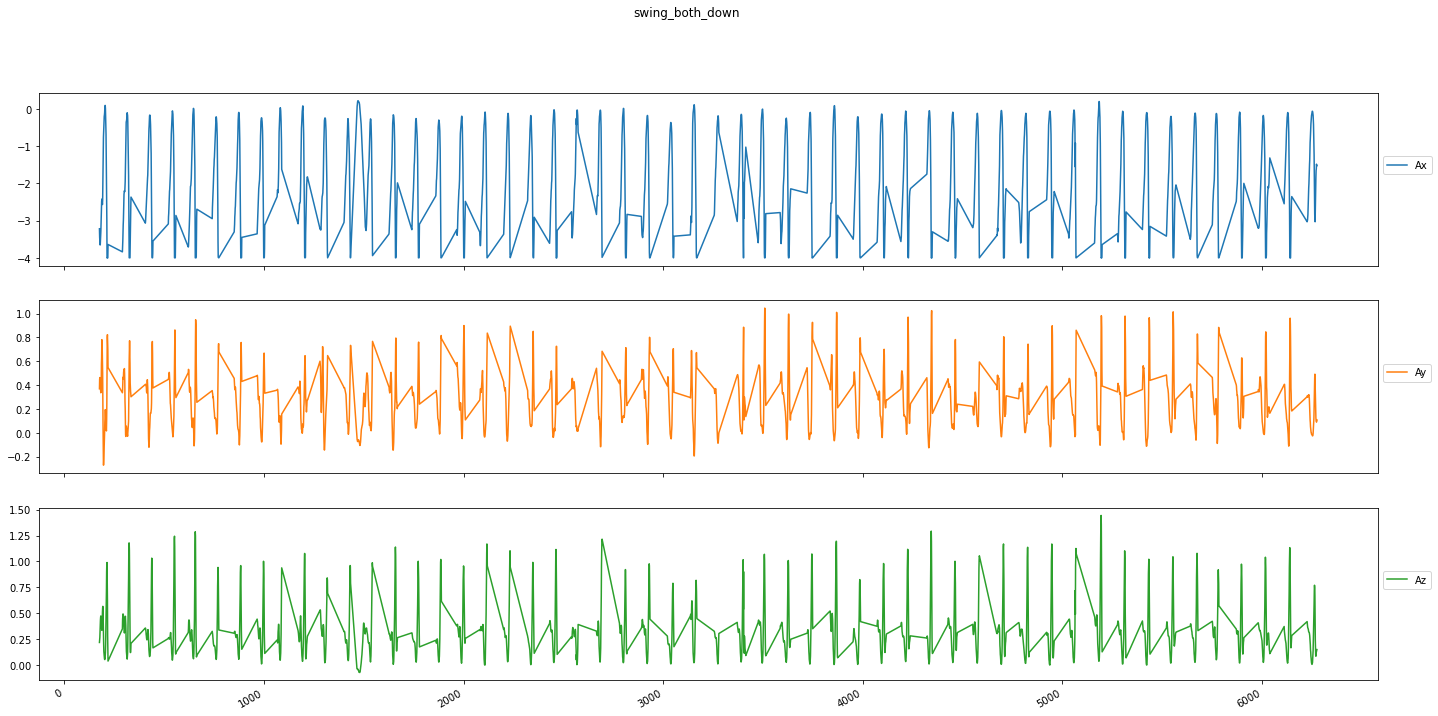

In [679]:


df = pd.DataFrame()
df = df.append([df_swing_b]).head(7000).copy()



plot_activity('Swing Both',df,h=0,i=10000)
plot_activity_part('swing_both_up',df,h=0,i=10000)
plot_activity_part('swing_both_down',df,h=0,i=10000)
#df_swing_l


label = LabelEncoder()
df['Label'] = label.fit_transform(df['Activity Part'])
df.head()
label.classes_
inputs,outputs = generate_samples(df,label,40,2400)


# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

model = Sequential()
#model.add(InputLayer(input_shape=inputs_train[0].shape))

#model.add(Conv2D(50,[2,2], activation='relu',input_shape=inputs_train[0].shape))
#model.add(Dropout(0.1))

#model.add(Conv2D(12,[2,2], activation='relu'))
#model.add(Dropout(0.2))

#model.add(Flatten())

#model.add(Dense(64, activation='relu'),input_shape=inputs_train[0].shape)
#model.add(Dropout(0.5))
NUM_GESTURES= len(label.classes_)
model = Sequential()
#model.add(Conv2D(50,[2,2], activation='relu',input_shape=inputs_train[0].shape))
model.add(Dense(16, activation='relu', input_shape =inputs_train[0].shape)) # relu is used for performance
model.add(Dense(16, activation='relu')) # relu is used for performance
model.add(Dropout(0.1)) # relu is used for performance
model.add(Dense(20, activation='relu')) # relu is used for performance
model.add(Dropout(0.2)) # relu is used for performance
model.add(Dense(16, activation='relu')) # relu is used for performance
model.add(Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','mae'])

In [680]:
history = model.fit(inputs_train, outputs_train, epochs=50, batch_size=10, validation_data=(inputs_validate, outputs_validate))

Epoch 1/50
8/8 [==============================] - 0s 32ms/step - loss: 1.0221 - accuracy: 0.4304 - mae: 0.4238 - val_loss: 0.9999 - val_accuracy: 0.3571 - val_mae: 0.4186
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0009 - accuracy: 0.4177 - mae: 0.4158 - val_loss: 0.9625 - val_accuracy: 0.3571 - val_mae: 0.4060
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.9614 - accuracy: 0.4177 - mae: 0.4000 - val_loss: 0.9311 - val_accuracy: 0.3571 - val_mae: 0.3935
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.9702 - accuracy: 0.4177 - mae: 0.3973 - val_loss: 0.9117 - val_accuracy: 0.3571 - val_mae: 0.3852
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.9438 - accuracy: 0.4051 - mae: 0.3902 - val_loss: 0.8989 - val_accuracy: 0.3571 - val_mae: 0.3807
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.9483 - accuracy: 0.3924 - mae: 0.3901 - val_loss: 0.8877 - val_accuracy: 0.35

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a46b1558e0>)

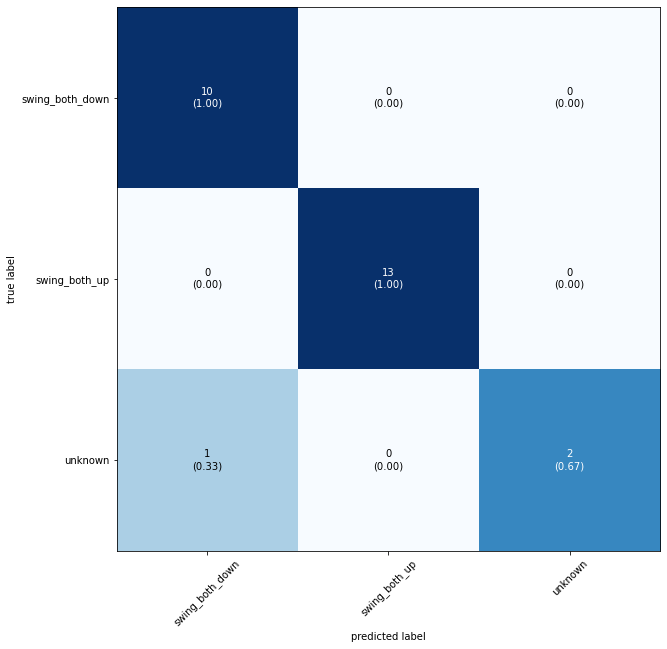

In [681]:
y_pred = model.predict_classes(inputs_test)


rounded_labels=np.argmax(outputs_test, axis=1)
rounded_labels[1]

mat = confusion_matrix(rounded_labels,y_pred)
plot_confusion_matrix(mat,class_names=label.classes_, show_normed=True,figsize=(10,10))

In [626]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("kettle.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("kettle.tflite")
print("Model is %d bytes" % basic_model_size)
label.classes_

INFO:tensorflow:Assets written to: C:\Users\niig\AppData\Local\Temp\tmphy_q0cjx\assets


INFO:tensorflow:Assets written to: C:\Users\niig\AppData\Local\Temp\tmphy_q0cjx\assets


Model is 21964 bytes


array(['swing_both_down', 'swing_both_up', 'unknown'], dtype=object)

In [58]:
# new frame with with all the activities
df = pd.DataFrame()
df = df.append([
    df_swing_l,
    df_swing_r,
    df_press_l,
    df_press_r])

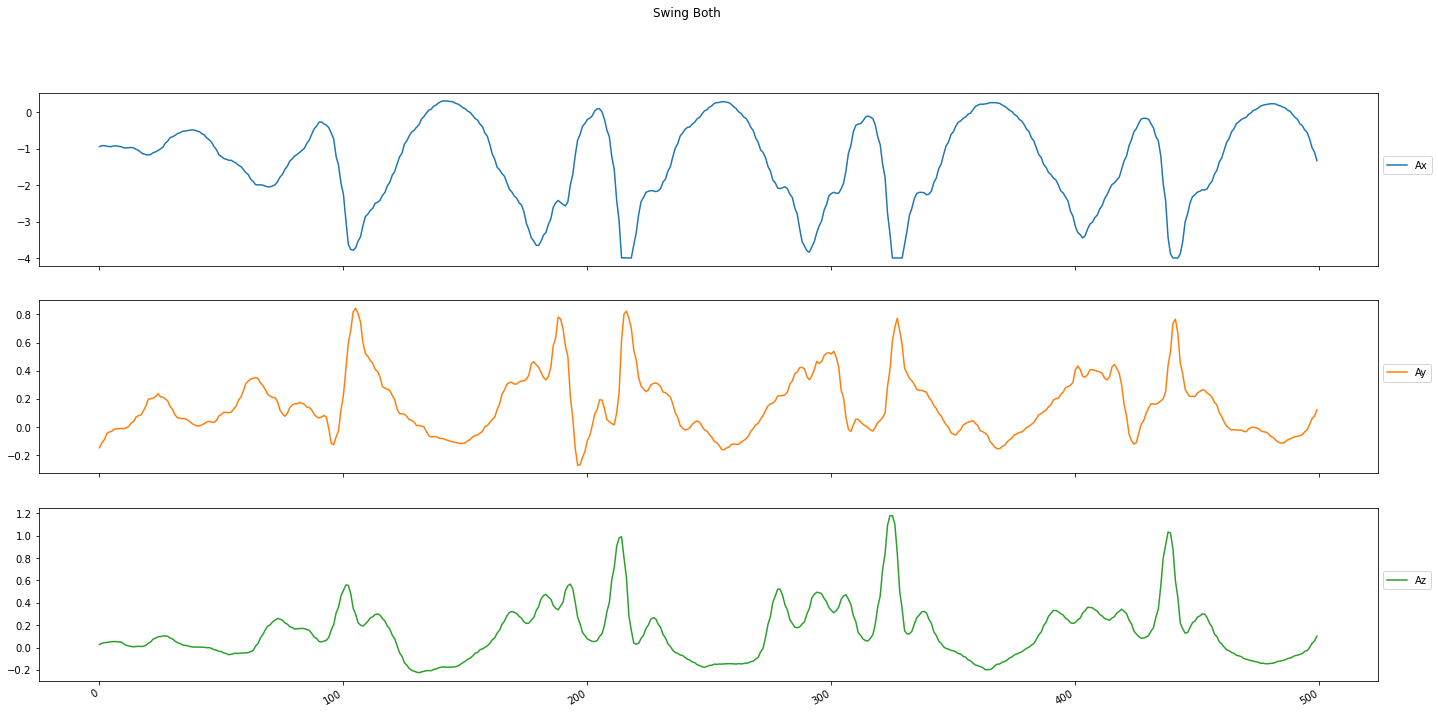

In [351]:

plot_activity('Swing Both',df_swing_b,i=500)

## Inspect the number of datapoints for each indivudal exercise 

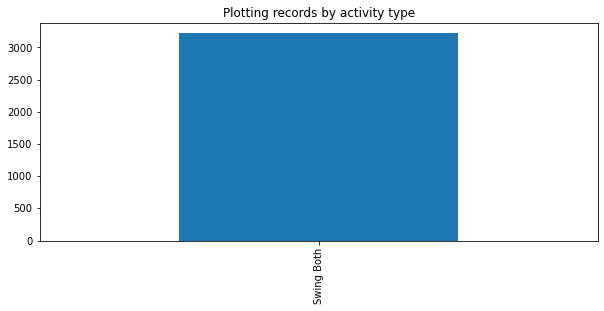

In [644]:
df['Activity'].value_counts().plot(kind='bar', title='Plotting records by activity type', figsize=(10, 4),align='center')

# Extract features
Normalize the accelerometer and gyroscope values and extract other features

In [643]:
frequency(df)

# Samping frequency 
The frequency is different for some of the sampling data due to the different methods that have been used for data recording.

Original prototype used to publish data over HTTP and esp32 was able to achieve a sampling rate of 50hz. 

After the first model has been trained the prediction data has been added to the samples, this decreased the sampling rate down to 25hz. This has been improved in the 3 version of the hardware where sampling rate including the prediction output is 100hz.

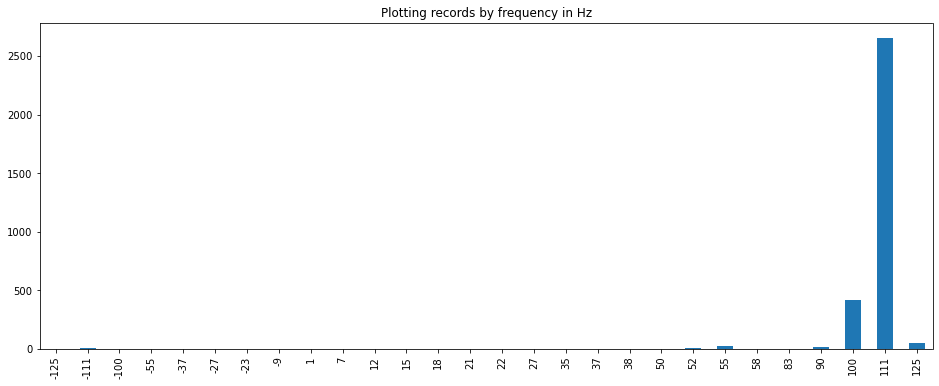

In [645]:
df['Hz'].value_counts().sort_index().plot(kind='bar', title='Plotting records by frequency in Hz', figsize=(16, 6),align='center')

## Frequency on log scale
TODO: Need to look into why there are some negative values, seems strange.

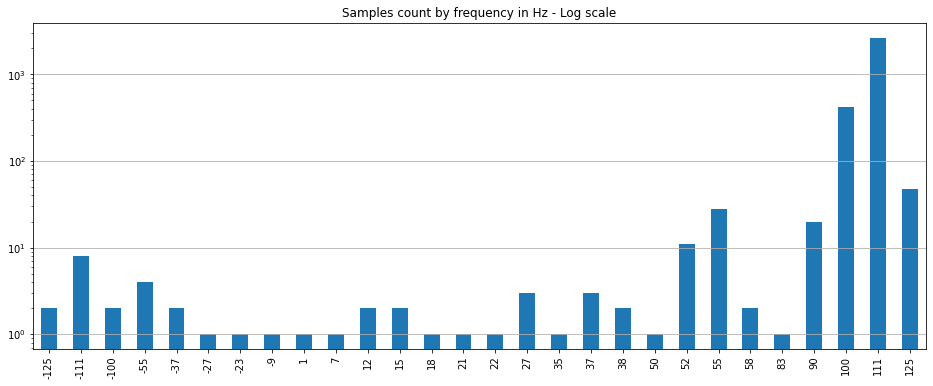

In [646]:
plt1 = df['Hz'].value_counts().sort_index().plot(kind='bar', title='Samples count by frequency in Hz - Log scale', figsize=(16, 6),align='center')
plt1.yaxis.grid()
plt1.set_yscale('log')